Assignment 5 Notebook 

Full name : Emily Moeller

Wisc Id : 9070376034

Jupyter verison : 4.2.1

In [1]:
import pandas as pd 
import numpy as np # numpy has a lots of useful math related modules
from IPython.display import display # Helpful function to display intermittent result

Step 0: Take a peak at the Data

In [2]:
import os
cwd = os.getcwd()
print(cwd + "\AQI.csv")
data_file = "./AQI.csv" # e.g ~/cs564/p5/AQI.csv"
display(pd.read_csv(data_file, nrows=5).head())

C:\Users\Emily\CS564p5\AQI.csv


,State Code,County Code,Latitude,Longitude,Date Local,AQI,Address,State Name,County Name,City Name,CBSA Name
0,55,59,42.504722,-87.8093,1997-04-28,82,"CHIWAUKEE PRAIRIE, 11838 FIRST COURT",Wisconsin,Kenosha,Pleasant Prairie,"Chicago-Naperville-Elgin, IL-IN-WI"
1,55,59,42.504722,-87.8093,1997-05-10,33,"CHIWAUKEE PRAIRIE, 11838 FIRST COURT",Wisconsin,Kenosha,Pleasant Prairie,"Chicago-Naperville-Elgin, IL-IN-WI"
2,55,59,42.504722,-87.8093,1997-05-16,25,"CHIWAUKEE PRAIRIE, 11838 FIRST COURT",Wisconsin,Kenosha,Pleasant Prairie,"Chicago-Naperville-Elgin, IL-IN-WI"
3,55,59,42.504722,-87.8093,1997-05-22,25,"CHIWAUKEE PRAIRIE, 11838 FIRST COURT",Wisconsin,Kenosha,Pleasant Prairie,"Chicago-Naperville-Elgin, IL-IN-WI"
4,55,59,42.504722,-87.8093,1997-05-28,46,"CHIWAUKEE PRAIRIE, 11838 FIRST COURT",Wisconsin,Kenosha,Pleasant Prairie,"Chicago-Naperville-Elgin, IL-IN-WI"


Step 1 : Load the dataset

In [3]:
from sqlalchemy import create_engine
import sqlite3
# create a database where we'll load the dataset from the csv file 
db_conn = create_engine('sqlite:///AirQualityIndex.db')

In [4]:
import string
# load in a batch of 5000 tuples. Modify this value to your needs
chunks = 5000
for data in pd.read_csv(data_file, chunksize=chunks,
 iterator=True, encoding='utf-8'):

 data = data.rename(columns={col: col.replace('-', ' ') for col in data.columns})
 data = data.rename(columns={col: col.strip() for col in data.columns})
 data = data.rename(columns={col: string.capwords(col) for col in data.columns})
 data = data.rename(columns={col: col.replace(' ', '') for col in data.columns})

 data.to_sql('data', db_conn, if_exists='append')

Step 2 : Data Exploration
Find the average air quality index for each city recorded during the year 1997

Query #1: 

In [50]:
worst_best_Aqi = pd.read_sql_query("""SELECT MAX(AQI) as AQI, Latitude, Longitude, DateLocal, 'worstAQI' as AQILevel,
                             CityName as city FROM data
                             UNION
                             SELECT MIN(AQI) as AQI, Latitude, Longitude, DateLocal, 'bestAQI' as AQILevel,
                             CityName as city FROM data""", db_conn)

# Display the result (Note - the result 'worstAqi' is an instance of 'pandas DataFrame')
display(worst_best_Aqi)

,AQI,Latitude,Longitude,DateLocal,AQILevel,city
0,0,33.331111,-87.003611,1999-06-21,bestAQI,Not in a city
1,593,38.274083,-91.701611,2001-09-13,worstAQI,Not in a city


Query #2: Not in a city v. in a city

In [46]:
rural_v_city = pd.read_sql_query("""SELECT AVG(AQI) as avg_aqi, 'NotInACity' as Location
                             FROM(SELECT AQI as aqi, CityName as city
                             FROM data
                             WHERE city = 'Not in a city')
                             UNION
                             SELECT AVG(AQI) as avg_aqi, 'InACity' as Location
                             FROM(SELECT AQI as aqi, CityName as city
                             FROM data
                             WHERE city != 'Not in a city')""""", db_conn)

display(rural_v_city)


,avg_aqi,Location
0,34.800566,NotInACity
1,40.960726,InACity


Query #3:

Madison v. Milwaukee v. Green Bay

In [45]:
madison_milwaukee_greenBay = pd.read_sql_query("""SELECT AVG(AQI) as avg_aqi, 'Madison' as City
                             FROM(SELECT AQI as aqi, CityName as city
                             FROM data
                             WHERE city = 'Madison')
                             UNION
                             SELECT AVG(AQI) as avg_aqi, 'Milwaukee' as City
                             FROM(SELECT AQI as aqi, CityName as city
                             FROM data
                             WHERE city != 'Milwaukee')
                             UNION
                             SELECT AVG(AQI) as avg_aqi, 'Green Bay' as city
                             FROM(SELECT AQI as aqi, CityName as city
                             FROM data
                             WHERE city != 'Green Bay')""""", db_conn)
display(madison_milwaukee_greenBay)

,avg_aqi,City
0,40.203168,Milwaukee
1,40.225482,Green Bay
2,41.716856,Madison


Step 3 : Data Visualization
Visualize the data you received above as plots

Data Visualization for Query 2

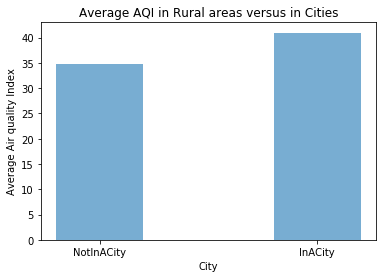

In [34]:
# Use matplotlib library to plot graph - a simple barchart in this case 
# We encourage you to explore different and more complex types of chart
import matplotlib.pyplot as plt


# First we convert the Dataframe object to Python list (that Matplotlib understands)
from pandas import DataFrame
# this is our 'y-axis' value - obtained by flattening the DataFrame object 
aqis_list = list(rural_v_city['avg_aqi'].values.flatten())
# This is our x-axis value 
location = list(rural_v_city['Location'].values.flatten())

# Specify the plot type and formatting 
plt.title('Average AQI in Rural areas versus in Cities')
y_pos = np.arange(len(location))
# Type of graph
plt.bar(y_pos, aqis_list, align='center', alpha=0.6, width=0.4)
# Specify 'ticks' on the x-axis for each item in the list for 'x-axis' values  
plt.xticks(y_pos, location)
plt.xlabel('City')
plt.ylabel('Average Air quality Index')
plt.show()
# Save this diagram(by default at the directory from where this application is launched)
plt.savefig("Rural_V_City.png")

                
Summary 
1. Write a brief summary of your findings here.

Query 1: The best AQI ever recorded was in Alabama in 1999 and the worst AQI recorded was in Missouri in 2001. Both the highest and lowest AQI are not located in cities.

Query 2: The average AQI in Cities is higher than in rural areas, but it is only a difference of 6.16 AQI values.

Query 3: The average AQIs in the three largest cities in Wisconsin are very similar despite the fact that Milwaukee is more than double the size of Madison and Madison is more than double the size of Green Bay. In fact, Madison had the highest AQI score of the three cities, but only by 1.49 AQI. In addition, Green Bay even had a higher average AQI score than Milwaukee. 
